#Multi-objective Probe Placement Optimization
This is based on a paper by Lou et al. (GT2020-14867 and GT2020-15465), Reconstructing Compressor Non-Uniform Circumferential Flow Field
from Spatially Undersampled Data.

##Problem Description
The flow in turbomachinery experiments is inherently nonuniform around the annulus, and understanding the circumferential variation of the flowfield is often critical to the technological advancement of both compressors and turbines. However, characterizing the circumferential variation of the flow field with high spatial resolution is often impractical: physical constraints limit the instrumentation that can be placed in the flow path, and circumferential probe traverses are costly and complex.

##Approach
There are two applications of circumferential signal reconstruction:<br>

  1) Rig design (spefically, probe placement)<br>
  2) Data analysis<br>

The routes for each application are shown in the figure below:
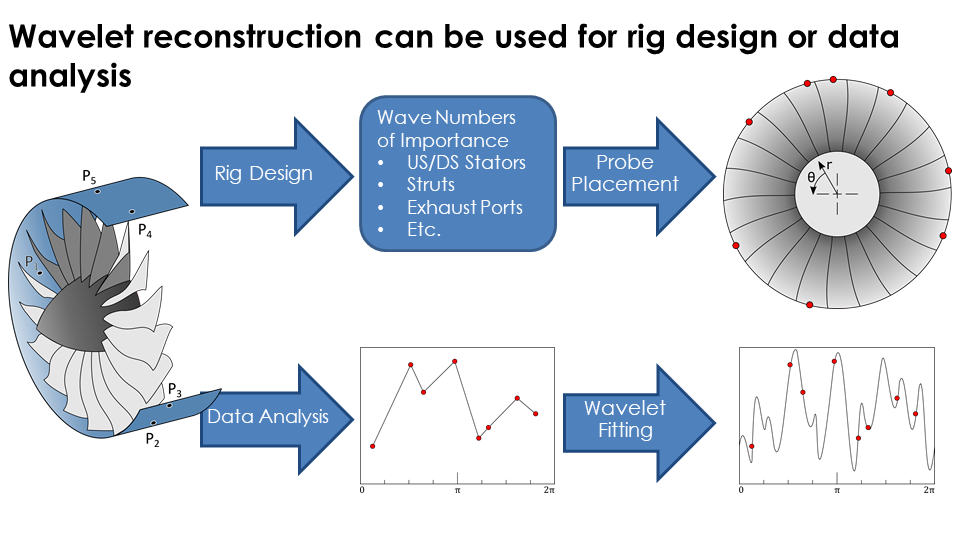

Concerning rig design, the primary wavenumbers of interest must be determined, and thus some knowledge of the machine is necessary. The most important wavenumbers are usually associated with upstream and downstream vane counts, as well as struts or rakes. Additionally, wavenubmers associated with the differences in count between the stationary components should also be considered. CFD simulations may also be used to resolve all wave numbers of interest. Once the key wavenumbers are identified, a design matrix consisting of the wavenumbers of interest and probe locations is constructed. The condition number of this matrix is optimized (the condition number should be as low as possible) to give ideal probe placement for characterization of the wavenumbers of interest. A key point: the number of probes (`nProbes`) must be greater than $2N+2$, when $N$ is the number of wavenumber being simultaneously considered.

For data analysis, the design matrix and measured data are used to determine the coefficients of the waveforms of interest contained in $F$ and solved from $AF=x$ where $x$ contains the experimental data. For further details, see the papers referenced above. The coefficients in $F$ are then used to reconstruct the signal around the entirety of the circumference of the machine.

The procedure given here determines the optimimum probe placement for a few wavenumbers of interest. The probe positions are output in `probeTheta`. The signal reconstruction possible from the optimized probe placement is then compared to the original signal.

#Step 1: Cloning the Project (House keeping)
Lets clone the test project in Glennopt. We will need the test folder located in GlennOPT/test/ProbePlacement_multi/parallel

In [1]:
# Clone the source code for GlennOPT
!git clone https://github.com/nasa/GlennOPT.git
# Little Housekeeping
!mkdir SingleObjective_Evaluate
!mkdir MultiObjective_Evaluate
!cp -r GlennOPT/test/ProbePlacement/parallel/Evaluation/* ./SingleObjective_Evaluate    # Copy the folder we need 
!cp -r GlennOPT/test/ProbePlacement_multi/parallel/Evaluation/* ./MultiObjective_Evaluate    # Copy the folder we need 
!rm GlennOPT/ -r        # Deletes GlennOPT source code. We don't need this anymore

Cloning into 'GlennOPT'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 1136 (delta 272), reused 346 (delta 177), pack-reused 669
Receiving objects: 100% (1136/1136), 1.88 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (651/651), done.


##Folder Structure and Evaluation Script
Here is a description of the code that you will be optimizing

italicized text###Initial folder structure
```
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to breakdown hosts per evaluation)
```

###After optimization
```
Calculation
| - DOE
| -- IND000
| ----- input.txt   (Generated by optimizer)
| ----- evaluate.py (Executes the cfd and reads results)
| ----- output.txt  (Generated by evaluate.py)
| -- ...
| -- IND128
| - POP000
| -- IND000
| -- ...
| -- IND039
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to break down hosts per evaluation)
```
Note: Glennopt constructs the calculation folder automatically. Each population is saved as DOE or as POPXXX. This is done so that when you are running a Computational Fluid Simulation or any kind of optimization where crashes could occur, you can investigate why the simulation crashed.

Also if there are any additional post processing that needs to be done, by saving the evaluations this way, it is also possible to re-process the files differently and restart the optimization. **Restarts** will be shown in a later section.


###Evaluation Script
You may have noticed that when in earler codes the github folder is cloned and part of it was copied and the rest of it was deleted. This is done to import the evaluation script found in Evaluation/evaluate.py

The purpose of this script is to call the Kursawe function (kur.py) to perform a single execution. The inputs will be read from an input.dat file and output to output.txt. See `read_input` and `print_output` functions

---

```
# evaluation.py
import time

# Load external modules 
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import signalProcessing as sig
import plotParty as pp
import waveletReconstruction as fLou
from scipy import stats
import itertools


'''
This example comes from the paper of 
RECONSTRUCTING COMPRESSOR NON-UNIFORM CIRCUMFERENTIAL FLOW FIELD
FROM SPATIALLY UNDERSAMPLED DATA 
GT2020-15465
'''

'''
Globals
'''
singleOrCombos = 'single' # only one wavenumber combination or try multiple combos
waveNumberGuesses = [[8,96,104]] # guesses of wave numbers

if singleOrCombos == 'combos':
    wnCombos = list()
    for i in range(1,len(waveNumberGuesses)+1):
        subCombos = [np.asarray(x) for x in itertools.combinations(waveNumberGuesses,i)]
        wnCombos.extend(subCombos)
else:
    wnCombos = waveNumberGuesses


#* define true signal parameters
def true_signal_construction():
    # define signal to reconstruct    
    fs        = 3600                                        # sample frequency in the spatial domain
    N         = 3600                                        # number of points around the circumference
    fKnown = np.asarray([8,48,72,80,88,96,104])             # wavenumbers for which there is known spatial content
    XKnown   = np.asarray([0.7,0.05,0.2,0.3,0.1,2.45,0.5])  # amplitudes of the signal corresponding to fKnown

    # use fKnown and XKnown to get the signal in the time domain
    t, x, _, _ = sig.signalFromSparseFrequency(fs, N, fKnown, XKnown)
   # convert to degrees and only take one revolution
    theta = t * 360
    theta = np.append(theta[theta<360],360)
    trueSignal  = np.append(x,x[0])
    tsInterp = interp1d(theta, trueSignal, kind='linear')

    # build highly-resolved wavenumber content from fKnown and XKnown
    step = max(theta)/(100*360)
    fHR = np.arange(0,max(theta)+step,step)
    XHR = np.zeros(len(fHR))
    for i,fhr in enumerate(fHR):
        for j,fk in enumerate(fKnown):
            if abs(fk-fhr) < step/10:
                XHR[i] = XKnown[j]

    # Plot the true signal 
    pp.setFigFormat('pres')
    # frequency plot of true signal
    # _, ax = plt.subplots(2,1)
    # ax[0].plot(fHR,XHR)
    # ax[0].set_xlim(0,120)
    # ax[0].set_xlabel('Wavenumber')
    # ax[0].set_ylabel('Signal Units')
    # yMax = round(max(XHR)*2)/2
    # ax[0].set_ylim(0,yMax)
    
    # time domain plot of true signal
    # ax[1].plot(theta,trueSignal)
    # ax[1].set_xlim(0,360)
    # ax[1].set_xlabel('Circumferential Position [$^\circ$]')
    # ax[1].set_ylabel('Signal Units')
    # yMin = round(min(trueSignal)*2)/2
    # yMax = round(max(trueSignal)*2)/2
    # ax[1].set_ylim(yMin, yMax)
    # plt.tight_layout()
    
    return theta, trueSignal, tsInterp

#* define objective function

# goal is to minimize condition number of design matrix
# low condition numbers give lowest error metrics

def objective_function(probeTheta, tsInterp, theta, trueSignal):
    '''
        Vary the location of probeTheta location so that we pick up the true signal
        Inputs
            probeTheta - this is what we are solving for
    '''  
    # the condition number of the design matrix A will be minimized.
    # first, the design 
    k = np.zeros(len(wnCombos))
    for j,wn in enumerate(wnCombos):
        A = fLou.buildDesignMatrix(probeTheta, wn)
        k[j] = np.linalg.cond(A)
    cost = np.sum(k**2)

    # Plot code 
    A = [None]*len(wnCombos)
    F = [None]*len(wnCombos)
    N = [None]*len(wnCombos)
    xR = [None]*len(wnCombos)
    signal = tsInterp(probeTheta)
    # do for best of each combination
    for i,wn in enumerate(wnCombos):
        F[i], A[i] = fLou.solveForWaveletCoefficients(probeTheta, signal, wn)
        xR[i] = np.zeros(len(theta))
        # for j,t in enumerate(theta):
        xRtemp = 0
        for j in np.arange(len(wn)):
            xRtemp = xRtemp + (F[i][2*j]*np.sin(wn[j]*theta*np.pi/180) +
                            F[i][2*j+1]*np.cos(wn[j]*theta*np.pi/180))
        xR[i] = xRtemp + F[i][-1]
        
    #%% check error in reconstructed signal

    pearsonR = np.zeros(len(wnCombos))
    rmsR     = np.zeros(len(wnCombos))
    for i in range(len(wnCombos)):
        pearsonR[i] = stats.pearsonr(trueSignal, xR[i])[0]
        rmsR[i]     = np.sqrt(1/len(trueSignal)*(np.sum((xR[i]-trueSignal)**2)))

    #%% visual evaluations for goodness of fit

    # bar chart of error metric
    xLabel = [str(wn) for wn in wnCombos]
    x      = np.arange(len(xLabel))
    width  = 0.35

    # make plot
    _, ax = plt.subplots(2, 1)
    # rects1 = ax[0].bar(x - width/2, pearsonR)
    # rects2 = ax[1].bar(x-width/2, rmsR)

    # format plot
    ax[0].set_ylabel('Pearson R')
    ax[1].set_ylabel('RMS Error')
    ax[0].set_ylim(0.75,1)
    for i in range(len(ax)):
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(xLabel)


    # line plot of true signal vs best reconstructed signal
    bestIndex     = np.argmax(pearsonR)
        
    plt.figure()
    plt.plot(theta,trueSignal)
    plt.plot(theta,xR[bestIndex],'--')
    plt.xlim((0,60))
    plt.savefig('signal_comparison.png')

    bestIndex     = np.argmax(pearsonR)

    return cost, pearsonR[bestIndex], rmsR[bestIndex]
        

#* GlennOPT helper code. Do not modify 
def read_input(input_filename):
    x = []
    with open(input_filename, "r") as f: 
        for line in f:
            split_val = line.split('=')
            if len(split_val)==2: # x1 = 2 # Grab the 2
                x.append(float(split_val[1]))
    return x
 
def print_output(y,perf=None):
    with open("output.txt", "w") as f:        
        f.write('objective1 = {0:.6f}\n'.format(y)) # Output should contain [Name of the Objective/Parameter] = [value] This is read by the optimizer 
        if perf is not None:
            f.write('PearsonR = {0:.6f}\n'.format(perf[0]))
            f.write('RMS_Error = {0:.6f}\n'.format(perf[1]))

if __name__ == '__main__':
    '''
        Main Execution code. Reads the inputs, finds the cost, outputs the cost.
        
    '''
    x = read_input("input.dat") 
    theta,trueSignal, tsInterp = true_signal_construction()
    y,pearson_r,rms_error = objective_function(x,tsInterp, theta, trueSignal)
    print_output(y,[pearson_r,rms_error])

```


###plotParty
Used for plotting stuff
```
# plotParty.py
#%% import modules

from cycler import cycler
import matplotlib

#%% instrTypeToStr

def instrTypeToStr(instrumentationType):
    """ 
    Subcategory indicating instrumentation type used converted to string
    for plot labels.
    
    <333 T. Harrison 10/2020
    
    Input:
        1) instrumentationType - string to convert to words for people
    
    Output:
        1) iStr - the string
    
    boomboomboom
    """
    ##########################################################################
    if instrumentationType == 'PS':
        iStr = 'Static Pressure'
    elif instrumentationType == 'PT':
        iStr = 'Total Pressure'
    elif instrumentationType == 'TS':
        iStr = 'Static Temperature'
    elif instrumentationType == 'TT':
        iStr = 'Total Temperature'
        
    return iStr

#%% setFigSize

def setFigFormat(figFormat):
    """ 
    Set figure size for either journal/conference paper or presentation.
    
    <333 T. Harrison 10/2020
    
    Input:
        1) figFormat - string - either 'paper' or 'presentation'
    
    Output:
        1) changed matplotlib rcParams
    """
    ##########################################################################
    if figFormat == 'paper' or figFormat == 'journal':
        matplotlib.rcParams['figure.figsize'] = (3.5, 2.625)
        matplotlib.rcParams['font.size'] = 8
    elif figFormat == 'presentation' or figFormat == 'pres':
        matplotlib.rcParams['figure.figsize'] = (6.4, 4.8)
        matplotlib.rcParams['font.size'] = 14
        matplotlib.rcParams['axes.xmargin'] = 0.5
    # return iStr

#%% define customer cycler for specified axes

def setCycler(ax=None):
    """ 
    Cycler set up to make plots in a way that Trey likes.
    Define cycler to apply to axes if provided. Also return the cycler.
    Ignore application to axes if axes not provided.
    
    <333 T. Harrison 9/2020
    
    Input:
        1) ax - optional - axes to apply cycler to
    
    Output:
        1) cc - cycler that Trey likes.
    """
    ##########################################################################
    # set up cycler
    
    cc = (cycler(color = ['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F', '#e377c2', '#7f7f7f', '#9467bd']) +
      cycler(ls     = ['-',  '--', ':',  '-.', '-',  '--', ':',  '-.', '-',  '--']) + 
      cycler(lw     = [1.75, 1.75, 2.00, 1.75, 1.75, 1.75, 2.00, 1.75, 1.75, 1.75]) + 
      cycler(marker = ['o',  's',  '^',  'D',  '>',  'p',  'o',  's',  '^',  'D'])  +
      cycler(ms     = [5.00, 4.50, 5.50, 4.50, 5.25, 5.50, 4.50, 4.50, 5.50, 4.50]) + 
      cycler(mew    = [1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50, 1.50]) + 
      cycler(mfc    = ['w',  'w',  'w',  'w',  'w',  'w',  'w',  'w',  'w',  'w',]))
    if ax is None:
        pass
    else:
        ax.set_prop_cycle(cc)    
    return cc
```


```
import numpy as np
##########################################################################
    # reconstruct full frequency content of signal
    # we assume frequency content not given is zero
    k  = np.arange(N)                       # number of frequencies in spectrum
    fk = k*fs/N                             # actual frequencies in spectrum
    X  = np.zeros(len(fk))                  # initialize amplitude of spectrum
    
    # assign values at known frequencies
    for i,f in enumerate(fk):
        if f in fKnown:
            X[i] = XKnown[f == fKnown]
    
    ##########################################################################
    # calculate inverse discrete fourier transform
    
    x = N*np.real(np.fft.ifft(X))
    dt = 1/fs
    t = np.arange(N)*dt
       
    return t, x, fk, X
```


### Wavelet Reconstruction
```
#waveletReconstruction.py
import numpy as np

def buildDesignMatrix(probeTheta, waveNumber):
    """
    Build the design matrix (A) from probe positions and the wavenumbers of
    interest. Use the design matrix and signal from the probes, x, to solve
    for the wavelet coefficients.
    
    <333 T. Harrison 10/2020
    
    Input:
        1) probeTheta - angular position of probes between 0 and 360
        2) waveNumber - waveNumbers of itnerest
    
    Output:
        1) design matrix A
    """
    ##########################################################################
    m          = len(probeTheta)
    N          = len(waveNumber)*2 + 1
    A          = np.zeros([m,N])
    for i,pt in enumerate(probeTheta):
        for j in range(len(waveNumber)):
            A[i,2*j]   = np.sin(waveNumber[j]*pt*np.pi/180)
            A[i,2*j+1] = np.cos(waveNumber[j]*pt*np.pi/180)
    
    # last column equals 1
    A[:,-1] = 1
    
    return A

#%% solveForWaveletCoefficients

def solveForWaveletCoefficients(probeTheta, x, waveNumber):
    """
   Use the design matrix, A, and signal from the probes, x, to solve
    for the wavelet coefficients (output in F).
    
    <333 T. Harrison 10/2020
    
    Input:
        1) probeTheta - angular position of probes between 0 and 360
        2) x - signal from probes corresponding to probeTheta
        3) waveNumber - waveNumbers of itnerest
    
    Output:
        1) design matrix A
        2) wavelet coefficients in array F
    """
    ##########################################################################
    
    A = buildDesignMatrix(probeTheta, waveNumber)
    F = np.linalg.lstsq(A,x,rcond=None)[0]
    
    return F, A
```


#Step 2: Install GlennOPT and lets get started

In [2]:
# Install GlennOPT 
!python --version
!pip install glennopt
import pandas as pd

Python 3.6.9
     |████████████████████████████████| 11.6MB 10.0MB/s 
  Created wheel for pydoe: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=8e2c0b6ad70d7076669a8b376a5d2c04702caf84165a85dd264abc0f56d92c1b
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
  Created wheel for diversipy: filename=diversipy-0.8-cp36-none-any.whl size=27513 sha256=226b0624366ed9c982e72beae4b2cb37be96b0d89ea5917596699e1282d185c3
  Stored in directory: /root/.cache/pip/wheels/49/89/f4/1c64e470a0af08f4aefb99efec615e5da7907435b975ab64a6
Successfully built pydoe diversipy
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


'1.1.3'

In [ ]:
# Restart the runtime
import os
os.kill(os.getpid(), 9)

Import relevant libraries

In [1]:
from glennopt.base import Parameter
from glennopt.helpers import mutation_parameters, de_mutation_type
from glennopt.sode import SODE, selection_type
from glennopt.nsga3 import NSGA3
from glennopt.DOE import Default,CCD,FullFactorial,LatinHyperCube
import numpy as np
import os

In [2]:
# Clean up
!rm -r Calculation  # Remove the calculation folder, lets start from scratch
!rm *.csv *.dat     # Remove the restart file and any log files generated

rm: cannot remove 'Calculation': No such file or directory
rm: cannot remove '*.csv': No such file or directory
rm: cannot remove '*.dat': No such file or directory


##Defining the Number of Probes
The number of probes (`nProbes`) is the number of probes which are placed during optmization. The `minSpacing` parameter is the nearest two probes may be to each other in degrees. The circumference is divided into `nProbes` sectors of ($360/$ `nProbes`)$^\circ$, and each sector may contain only one probe. This ensures the probes are distributed around the full annulus rather than clustered together.

In the case that there is uncertainty concerning the combination of dominant wavenumbers, multiple combinations of wavenumbers can be optimized such that probe placement allows for characterization of various combinations of wavenumbers.

##Step 2 Single Objective Define Probe and Evaluation Parameters

In [3]:
# Initialize the DOE 
doe = LatinHyperCube(samples=128,levels=4) # 128 random samples of the design space
# These are also available for use
# doe = FullFactorial(levels=2) 
# doe = Default(15) # Default
# doe = CCD()

In [4]:
# Define evaluation parameters 
nProbes = 10
minSpacing = 3
probeSpacing = 360/nProbes
tLo     = np.zeros(nProbes)
tHi     = np.zeros(nProbes)
for i in range(nProbes):
    tLo[i] = probeSpacing*i
    if i != nProbes-1:
        tHi[i] = probeSpacing*(i+1) - minSpacing
    else:
        tHi[-1] = probeSpacing*(i+1)    
    doe.add_parameter(name="x"+str(i+1),min_value=tLo[i],max_value=tHi[i])
constraints = (tLo,tHi)

# Define the number of objectives

doe.add_objectives(name='objective1')

# Define any performance parameters you want to keep track of (tracking only)
doe.add_perf_parameter(name='PearsonR')
doe.add_perf_parameter(name='RMS_Error')

In [5]:
# Set up the optimizer
current_dir = os.getcwd()
pop_size = 64
sode = SODE(eval_script = "SingleObjective_Evaluate/evaluation.py", eval_folder="SingleObjective_Evaluate",pop_size=pop_size,optimization_folder=current_dir)

# Include load the objectives, performance parameters, evaluation parameters into sode
sode.add_eval_parameters(doe.eval_parameters)
sode.add_objectives(doe.objectives)
sode.add_performance_parameters(doe.perf_parameters)

In [6]:
# Parallel Settings (You don't need to run this block if you only want serial execution)
sode.parallel_settings.concurrent_executions = 8    # Change to 1 for serial
sode.parallel_settings.cores_per_execution = 1    
sode.parallel_settings.execution_timeout = 0.2      # minutes

# Start the optimizer
sode.mutation_params.mutation_type = de_mutation_type.de_dmp # de_mutation_type.de_rand_1_bin
sode.mutation_params.F = 0.6
sode.mutation_params.C = 0.7
individuals = doe.generate_doe()
print(len(individuals))

100%|██████████| 128/128 [00:00<00:00, 4455.43it/s]

x1 had more than two levels. Assigning the end point to the high level.
x2 had more than two levels. Assigning the end point to the high level.
x3 had more than two levels. Assigning the end point to the high level.
x4 had more than two levels. Assigning the end point to the high level.
x5 had more than two levels. Assigning the end point to the high level.
x6 had more than two levels. Assigning the end point to the high level.
x7 had more than two levels. Assigning the end point to the high level.
x8 had more than two levels. Assigning the end point to the high level.
x9 had more than two levels. Assigning the end point to the high level.
x10 had more than two levels. Assigning the end point to the high level.
128


In [7]:
# Runs the DOE
sode.start_doe(individuals)

In [ ]:
# Run the Optimization
sode.optimize_from_population(pop_start=-1,n_generations=50,sel_type=selection_type.pop_dist) # selection_type.best_design


  2%|▏         | 1/49 [00:38<30:38, 38.29s/it]

#Step 2.5: Multi-Objective Define Probe and Evaluation Parameters

## Setting up the problem

In [ ]:
!rm -r Calculation  # Remove the calculation folder, lets start from scratch
!rm *.csv *.log     # Remove the restart file and any log files generated

In [ ]:
# Define evaluation parameters 
nProbes = 10
minSpacing = 3
probeSpacing = 360/nProbes
tLo     = np.zeros(nProbes)
tHi     = np.zeros(nProbes)
for i in range(nProbes):
    tLo[i] = probeSpacing*i
    if i != nProbes-1:
        tHi[i] = probeSpacing*(i+1) - minSpacing
    else:
        tHi[-1] = probeSpacing*(i+1)    
    doe.add_parameter(name="x"+str(i+1),min_value=tLo[i],max_value=tHi[i])
constraints = (tLo,tHi)

doe = LatinHyperCube(samples=128,levels=5)
doe.add_objectives(name='objective1')
doe.add_objectives(name='objective2')

# Define any performance parameters you want to keep track of (tracking only)
doe.add_perf_parameter(name='PearsonR')
doe.add_perf_parameter(name='RMS_Error')

In [ ]:
# Set up the optimizer
current_dir = os.getcwd()
pop_size = 48
ns = NSGA3(eval_script = "MultiObjective_Evaluate/evaluation.py", eval_folder="MultiObjective_Evaluate",pop_size=pop_size,optimization_folder=current_dir)

Enable Parallel Execution (OPTIONAL) works the same for single objective

In [ ]:
# Parallel Settings (You don't need to run this block if you only want serial execution)
ns.parallel_settings.concurrent_executions = 8    # Change to 1 for serial
ns.parallel_settings.cores_per_execution: 1    
ns.parallel_settings.execution_timeout = 0.2      # minutes

In [ ]:
# Start the optimizer
ns.mutation_params.mutation_type = de_mutation_type.de_rand_1_bin
ns.mutation_params.F = 0.6
ns.mutation_params.C = 0.7
ns.start_doe(doe.generate_doe())
ns.optimize_from_population(pop_start=-1,n_generations=150)

#Step 3 Plotting the Results


##(Multi-Objective) Anmated Plot of all individuals
This is an example of an animated plot. It may take a while to run depending on the number of frames and the interval

In [ ]:
###Visualizing the Results
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from IPython.display import HTML

num_frames = 150

xlim = [-20,0]
ylim = [-15,20]
obj1_name = 'objective1'
obj2_name = 'objective2'

ns.read_calculation_folder()

fig,ax = plt.subplots(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')

keys = list(ns.pandas_cache.keys())
keys.sort()
nPop = len(list(ns.pandas_cache.keys()))
divisor = num_frames/nPop
def init():  
  data = get_data(0)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)
  ax.set_xlim(xlim[0],xlim[1])
  ax.set_ylim(ylim[0],ylim[1])  
  ax.set_xlabel(obj1_name)
  ax.set_ylabel(obj2_name)
  #pop_scatter.set_array(np.array([]))
  return pop_scatter,

def get_data(pop):  
  key = keys[pop]
  obj_data = list()
  for index, row in ns.pandas_cache[key].iterrows():
    obj_data.append([row[obj1_name],row[obj2_name]])
  return np.array(obj_data)

def animate(pop):
  pop = int(pop/divisor)
  data = get_data(pop)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)  
  ax.legend([str(pop)])
  return pop_scatter,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=num_frames, interval=10, blit=True)
HTML(anim.to_html5_video())
ax.clear()

##(Single/Multi) Best objective value vs population

In [ ]:
# Imports 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from glennopt.helpers import get_best,get_pop_best

In [ ]:
individuals = sode.read_calculation_folder()
objectives, pop, _ = get_best(individuals,pop_size=20)  # pop_size number of individuals to keep track of going from population to population
objective_index = 0 
_, ax = plt.subplots(figsize=(8,6),dpi=150)
ax.scatter(pop, objectives[:,objective_index],color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
plt.show()

##(Single/Multi) Best Individual at each Population

In [ ]:
best_individuals, best_fronts = get_pop_best(individuals)

nobjectives = len(best_individuals[0][0].objectives)
objective_data = list()
for pop,best_individual in best_individuals.items():
    objective_data.append(best_individual[objective_index].objectives[objective_index])

_, ax = plt.subplots(figsize=(8,6),dpi=150)
colors = cm.rainbow(np.linspace(0, 1, len(best_individuals.keys())))
ax.scatter(list(best_individuals.keys()), objective_data, color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
ax.set_title('Best individual at each population')
plt.show()

## (Multi-objective) Pareto Front
The code below shows how the pareto front evolves as the population advances.
**Note: this only applies to the multi-objective optimization of the probe**

In [ ]:
best_individuals, best_fronts = get_pop_best(individuals)
objectives, pop, best_fronts = get_best(individuals,pop_size=30)

fig,ax = plt.subplots(figsize=(10,8))

colors = cm.rainbow(np.linspace(0, 1, len(best_fronts)))        
indx = 0
legend_labels = []
# Scan the pandas file, grab objectives for each population
for ind_list in best_fronts:
    obj1_data = []
    obj2_data = []
    c=colors[indx]
    for ind in ind_list[0]:
        obj1_data.append(ind.objectives[0])
        obj2_data.append(ind.objectives[1])
    # Plot the gathered data
    ax.scatter(obj1_data, obj2_data, color=c, s=20,alpha=0.5)
    legend_labels.append(pop[indx])
    indx+=1

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_title('Non-dimensional sorting: Best Front for each population')
ax.legend(legend_labels)
fig.canvas.draw()
fig.canvas.flush_events()
plt.show()

##(Single/Multi) Plotting the Optimization History File
Code below shows how to plot the convergence of the optimizer. Convergence can be determined from the diversity which takes into account the change in the evaluation parameter. The second metric is to look at the population distance. Population distance compares the objective value of the individuals with the previous population's


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

history = pd.read_csv('history.csv')
history.plot(x='Population', y='pop_diversity', style='o')
plt.title('Population Diversity vs Population')
plt.ylabel('Population Diversity')



history.plot(x='Population', y='pop_avg_distance', style='o')
plt.title('Population distance vs Population')
plt.ylabel('Population Distance')

# Understanding the Results - Visualization

## Extract some functions from Evaluation.py
Please run the following code blocks in this section to load the functions in memory

In [ ]:
# Relevant Imports 
import numpy as np
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
def signalFromSparseFrequency(fs, N, fKnown, XKnown):
    """
    reconstruct a signal in the time domain from sparse frequency content.
    useful for getting time signal of (without phase info) from digitized
    frequency plots.
    
    <333 T. Harrison 09/2020
    
    Inputs:
        1) fs - sample frequency
        2) N - number of points
        3) fKnown - frequency data at known values
        4) XKnown - amplitude data corresponding to fKnown
            
    Outputs:
        1) t - time domain data
        2) x - x(t)
    
    Notes:
        1) Will you shut up, man?
    """
    ##########################################################################
    # reconstruct full frequency content of signal
    # we assume frequency content not given is zero
    k  = np.arange(N)                       # number of frequencies in spectrum
    fk = k*fs/N                             # actual frequencies in spectrum
    X  = np.zeros(len(fk))                  # initialize amplitude of spectrum
    
    # assign values at known frequencies
    for i,f in enumerate(fk):
        if f in fKnown:
            X[i] = XKnown[f == fKnown]
    
    ##########################################################################
    # calculate inverse discrete fourier transform
    
    x = N*np.real(np.fft.ifft(X))
    dt = 1/fs
    t = np.arange(N)*dt
       
    return t, x, fk, X

In [ ]:
def true_signal_construction():
  # define signal to reconstruct    
  fs        = 3600
  N         = 3600
  fKnown = np.asarray([8,48,72,80,88,96,104])
  XKnown   = np.asarray([0.7,0.05,0.2,0.3,0.1,2.45,0.5])

  t, x, f, X = signalFromSparseFrequency(fs, N, fKnown, XKnown)


  # convert to degrees and only take one revolution
  theta = t * 360
  theta = np.append(theta[theta<360],360)
  trueSignal  = np.append(x,x[0])
  tsInterp = interp1d(theta, trueSignal, kind='linear')

  step = max(theta)/(100*360)
  fHR = np.arange(0,max(theta)+step,step)
  XHR = np.zeros(len(fHR))
  for i,fhr in enumerate(fHR):
      for j,fk in enumerate(fKnown):
          if abs(fk-fhr) < step/10:
              XHR[i] = XKnown[j]

  return theta,trueSignal,tsInterp

In [ ]:
def buildDesignMatrix(probeTheta, waveNumber):
    """
    Build the design matrix (A) from probe positions and the wavenumbers of
    interest. Use the design matrix and signal from the probes, x, to solve
    for the wavelet coefficients.
    
    <333 T. Harrison 10/2020
    
    Input:
        1) probeTheta - angular position of probes between 0 and 360
        2) waveNumber - waveNumbers of itnerest
    
    Output:
        1) design matrix A
    """
    m          = len(probeTheta)
    N          = len(waveNumber)*2 + 1
    A          = np.zeros([m,N])
    for i,pt in enumerate(probeTheta):
        for j in range(len(waveNumber)):
            A[i,2*j]   = np.sin(waveNumber[j]*pt*np.pi/180)
            A[i,2*j+1] = np.cos(waveNumber[j]*pt*np.pi/180)
    
    # last column equals 1
    A[:,-1] = 1
    
    return A

def solveForWaveletCoefficients(probeTheta, x, waveNumber):
    """
    Use the design matrix, A, and signal from the probes, x, to solve
    for the wavelet coefficients (output in F).
    
    <333 T. Harrison 10/2020
    
    Input:
        1) probeTheta - angular position of probes between 0 and 360
        2) x - signal from probes corresponding to probeTheta
        3) waveNumber - waveNumbers of itnerest
    
    Output:
        1) design matrix A
        2) wavelet coefficients in array F
    """    
    A = buildDesignMatrix(probeTheta, waveNumber)
    F = np.linalg.lstsq(A,x,rcond=None)[0]
    
    return F, A

## Plotting a Single Design
The code block below loads the plotting part of the code which will be used later by the single and multi-objective optimizations

In [ ]:
def PlotCode(wnCombos,probeTheta,theta):
  A = [None]*len(wnCombos)         # design matrix for each wnCombo
  F = [None]*len(wnCombos)         # coefficient matrix for each wnCombo
  k = [None]*len(wnCombos)         # condition number for each wnCombo
  xR = [None]*len(wnCombos)        # reconstructed signal for each wnCombo
  signal = tsInterp(probeTheta)    # interpolator to give "measured signal" at each probeTheta
  # do for best of each wnCombo
  for i,wn in enumerate(wnCombos):
      F[i], A[i] = solveForWaveletCoefficients(probeTheta, signal, wn)
      k[i]  = np.linalg.cond(A[i])
      xR[i] = np.zeros(len(theta))
      # for j,t in enumerate(theta):
      xRtemp = 0
      for j in np.arange(len(wn)):
          xRtemp = xRtemp + (F[i][2*j]*np.sin(wn[j]*theta*np.pi/180) +
                          F[i][2*j+1]*np.cos(wn[j]*theta*np.pi/180))
      xR[i] = xRtemp + F[i][-1]

  #%% check error in reconstructed signal
  pearsonR = np.zeros(len(wnCombos))
  rmsR     = np.zeros(len(wnCombos))
  for i in range(len(wnCombos)):
      pearsonR[i] = stats.pearsonr(trueSignal, xR[i])[0]
      rmsR[i]     = np.sqrt(1/len(trueSignal)*(np.sum((xR[i]-trueSignal)**2)))

  ################################################################################
  # condition number bar plot

  # set up plot parameters
  xLabel = ['+'.join([str(wn) for wn in wnc]) for wnc in wnCombos]
  x      = np.arange(len(xLabel))
  width  = 0.5

  # make plot
  fig, ax = plt.subplots(1, 1)
  rects1 = ax.bar(x, k)
  ax.plot([0-width,max(x)+width],[4,4],'--k',label='Recommended Max Condition Number')

  # format plot
  ax.set_xticks(x)
  ax.set_xlim(0-width,max(x)+width)
  ax.set_xticklabels(labels=x,rotation=45)
  ax.set_xticklabels(xLabel)
  ax.set_xlabel('Wave Number Combination')
  ax.set_ylabel('Condition Number')
  ax.legend()

  ################################################################################
  # error bar plot

  # set up plot
  xLabel = ['+'.join([str(wn) for wn in wnc]) for wnc in wnCombos]
  x      = np.arange(len(xLabel))
  width  = 0.5

  # make plot
  fig, ax = plt.subplots(2, 1)
  fig.set_size_inches(fig.get_figwidth(), fig.get_figheight()*1.5)
  rects1 = ax[0].bar(x, pearsonR)
  rects2 = ax[1].bar(x, rmsR)

  # format plot
  for axi in ax:
      axi.set_xticks(x)
      axi.set_xticklabels(labels=x,rotation=45)
      axi.set_xticklabels(xLabel)
      axi.set_xlabel('Wave Number Combination')
      # axi.grid(True)
  ax[0].set_ylabel('Pearson R')
  ax[1].set_ylabel('RMS Error')
  ax[0].set_ylim(0,1)


  ################################################################################
  # true signal vs reconstructed signal
  
  # line plot of true signal vs best reconstructed signal
  for i in range(0,len(wnCombos)):
      wnStr = '+'.join([str(wn) for wn in wnCombos[i]])
      fig, ax = plt.subplots(1,1)
      ax.plot(theta, trueSignal,'-k', label='Experimental Data')
      ax.plot(theta,xR[i], 'g--', label='Reconstructed Signal for WN='+wnStr, marker='')
      
      plt.xlim(0, 360)
      xTick = 60
      ax.set_xticks(np.arange(0,360+xTick,xTick))
      ax.set_xlabel('Circumferential Position [$^\circ$]')
      ax.set_ylabel('Normalized Pressure')
      # ax.set_ylim(0.85,1.30)
      leg = ax.legend(loc='upper left')

## (Single Objective) Plotting the best design

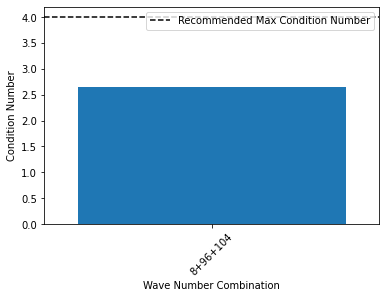

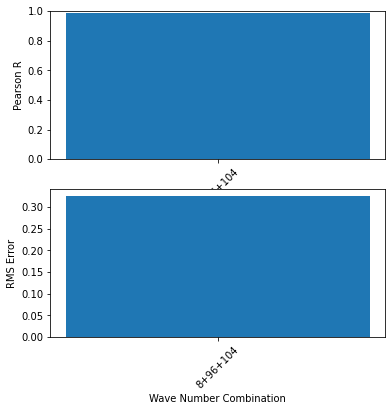

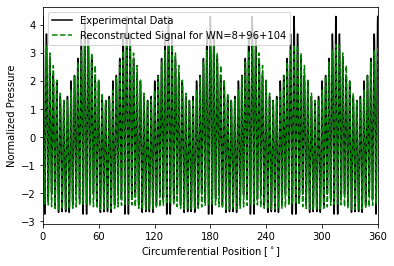

In [ ]:
import operator
# Run this for single objectve
pop_individuals = sode.read_calculation_folder()
all_individuals = [ind for inds in pop_individuals for ind in inds]
# Sorting using objective
individuals = sorted(all_individuals, key=operator.attrgetter('objectives')) # This returns a single value, hence it can be sorted. For multi-objective, the best design is chosen from the pareto front based on which objective you are trying to minimize
best_ind = individuals[0]


wnCombos = [[8,96,104]] # Wave Number combinations
theta,trueSignal,tsInterp = true_signal_construction()
PlotCode(wnCombos,best_ind.eval_parameters,theta)